In [1]:
import pandas as pd
import numpy as np
from math import sin, cos, sqrt, atan2, radians
from tqdm import tqdm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import mean_squared_error
import lightgbm as lgb
from sklearn.model_selection import train_test_split

In [2]:
def rmse(y_true, y_pred):
    return sqrt(mean_squared_error(y_true, y_pred))

In [3]:
train = pd.read_csv('train.csv', index_col=0)

In [4]:
test = pd.read_csv('test.csv', index_col=0)

In [5]:
train['isTrain'] = True
test['isTrain'] = False

In [6]:
X = train.append(test, sort=False)

In [7]:
X.describe().T

,count,mean,std,min,25%,50%,75%,max
id,8765.0,4404.586366,2542.532548,1.000000,2207.000000,4403.000000,6603.000000,8811.000000
atm_group,8765.0,4407.008842,2427.934099,32.000000,1942.000000,5478.000000,5478.000000,8083.000000
lat,8345.0,54.138304,4.329293,42.057080,52.243997,55.060936,56.116673,69.495093
long,8345.0,63.500873,32.787366,19.941530,37.851107,49.071694,84.950218,173.706490
target,6261.0,0.000715,0.085852,-0.145001,-0.061176,-0.015573,0.040149,0.218608


In [8]:
X.describe(include='object').T

,count,unique,top,freq
address,8765,7481,"HOROSHEVSKOE SH,V38 MOSKVA",7
address_rus,8345,6147,"квартал В-13, городской округ Волгодонск, Рост...",10


### Количество банкоматов стоящих по одному адресу

In [9]:
counts = X.groupby('address_rus')['id'].count().reset_index().rename(columns={'id':'count'})

In [10]:
X = pd.merge(X, counts, how='left', on='address_rus')

In [11]:
X.head()

,id,atm_group,address,address_rus,lat,long,target,isTrain,count
0,8526.0,32.0,"EMELYANOVA,34 Y-SAKHALINSK","улица А.О. Емельянова, 34, Южно-Сахалинск, Сах...",46.940995,142.738319,0.011500,True,1.0
1,8532.0,32.0,"KOMSOMOLSKAYA,259B Y.SAKHALINSK","Комсомольская улица, 259, Южно-Сахалинск, Саха...",46.937353,142.753348,0.029710,True,1.0
2,8533.0,32.0,"KOMMUN. PR., 32 YUZHNO SAKHAL","Коммунистический проспект, Южно-Сахалинск, Сах...",46.959413,142.741113,0.009540,True,1.0
3,8684.0,32.0,"LENINGRADSKIY PR.,76A MOSCOW","Ленинградский проспект, 76А, Москва, Россия, 1...",55.805827,37.515146,-0.094035,True,1.0
4,37.0,32.0,"GVARDEYSKAYA PL., 2 NORILSK","Гвардейская площадь, 2, Норильск, Красноярский...",69.343541,88.211228,0.079277,True,1.0


### Расстояния до ближайших банкоматов

In [12]:
R = 6373.0 # радиус земли в километрах

def distance(x,y):
    """
    Параметры
    ----------
    x : tuple, широта и долгота первой геокоординаты 
    y : tuple, широта и долгота второй геокоординаты 
    
    Результат
    ----------
    result : дистанция в километрах между двумя геокоординатами
    """
    lat_a, long_a, lat_b, long_b = map(radians, [*x,*y])    
    dlon = long_b - long_a
    dlat = lat_b - lat_a
    a = sin(dlat/2)**2 + cos(lat_a) * cos(lat_b) * sin(dlon/2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    return R * c

In [13]:
knc = KNeighborsClassifier(metric=distance)

In [14]:
dots = X[['lat','long']].dropna()

In [15]:
knc.fit(X=dots , y=np.ones(dots.shape[0]))

KNeighborsClassifier(algorithm='auto', leaf_size=30,
           metric=<function distance at 0x000001E4E86D1950>,
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

In [16]:
distances, indexes = knc.kneighbors(X=dots,n_neighbors=6,)

In [17]:
for i in range(1,6):
    dots['distance_%s'%i] = distances[:,i]
    dots['indexes_%s'%i] = indexes[:,i]

In [18]:
dots['mean'] = dots.iloc[:,dots.columns.str.contains('distance')].mean(axis=1)

In [19]:
X = pd.concat([X,dots], axis=1)

### Город размещения

In [20]:
X['city'] = X[~X.address_rus.isnull()].address_rus.apply(lambda x: x.split(',')[2]) 

In [21]:
rare_cities = X.city.value_counts()[(X.city.value_counts() < 20) ==True].index

In [22]:
X.city = X.city.apply(lambda x: 'RARE' if x in rare_cities else x)

In [23]:
X.city= X.city.rank().fillna(-1)

In [24]:
X_ = X[X.isTrain][['atm_group', 'lat', 'long',  'count', 'distance_1',
                    'distance_2',  'distance_3',  'distance_4', 'distance_5',
                    'indexes_5', 'mean', 'city']]
Y_ = X.loc[X.isTrain, 'target']

In [25]:
X_train, X_valid, Y_train, Y_valid = train_test_split(X_, Y_, test_size=0.25, random_state=1)

In [26]:
gbm = lgb.LGBMRegressor(objective = 'regression',  
                            max_depth = 3,
                            colsample_bytre = 0.8,
                            subsample = 0.8, 
                            learning_rate = 0.1,
                            n_estimators = 300)

In [27]:
gbm.fit(X_train, Y_train, eval_set=[(X_valid, Y_valid)], eval_metric='rmse', early_stopping_rounds=5)

[1]	valid_0's rmse: 0.0792103
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's rmse: 0.0745175
[3]	valid_0's rmse: 0.0705317
[4]	valid_0's rmse: 0.0671016
[5]	valid_0's rmse: 0.0641692
[6]	valid_0's rmse: 0.0616998
[7]	valid_0's rmse: 0.0595902
[8]	valid_0's rmse: 0.0575512
[9]	valid_0's rmse: 0.056037
[10]	valid_0's rmse: 0.054788
[11]	valid_0's rmse: 0.0536961
[12]	valid_0's rmse: 0.0526001
[13]	valid_0's rmse: 0.0517706
[14]	valid_0's rmse: 0.0509879
[15]	valid_0's rmse: 0.0504143
[16]	valid_0's rmse: 0.0499533
[17]	valid_0's rmse: 0.0495757
[18]	valid_0's rmse: 0.0491666
[19]	valid_0's rmse: 0.0488564
[20]	valid_0's rmse: 0.0485702
[21]	valid_0's rmse: 0.0483905
[22]	valid_0's rmse: 0.0481961
[23]	valid_0's rmse: 0.0479803
[24]	valid_0's rmse: 0.0478828
[25]	valid_0's rmse: 0.0477505
[26]	valid_0's rmse: 0.047599
[27]	valid_0's rmse: 0.047524
[28]	valid_0's rmse: 0.0474433
[29]	valid_0's rmse: 0.0473823
[30]	valid_0's rmse: 0.0472947
[31]	valid_0's rmse: 0

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytre=0.8,
       colsample_bytree=1.0, learning_rate=0.1, max_depth=3,
       min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
       n_estimators=300, n_jobs=-1, num_leaves=31, objective='regression',
       random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
       subsample=0.8, subsample_for_bin=200000, subsample_freq=0)

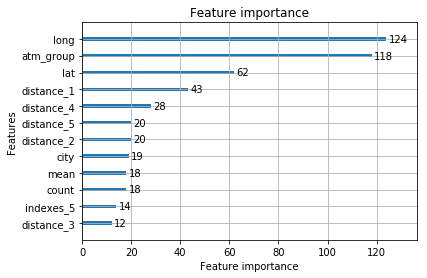

In [28]:
%matplotlib inline
lgb.plot_importance(gbm)

In [29]:
rmse(Y_valid, gbm.predict(X_valid))

0.045904893145415314

In [30]:
rmse(Y_valid, np.zeros(Y_valid.shape[0]))

0.08463725683992336

In [31]:
X_test = X[~X.isTrain][['atm_group', 'lat', 'long',  'count', 'distance_1',
                        'distance_2', 'distance_3',  'distance_4', 'distance_5',
                        'indexes_5', 'mean', 'city']]

In [32]:
submit = pd.DataFrame(gbm.predict(X_test), index=test.index,columns=['target'])

In [35]:
submit.to_csv('submit.csv')